<center>
    <h1>Assignment 2 - Question Answering with Transformers on CoQA</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment.ipynb`.

In this notebook the QA task is addressed.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `utils` folder.

In [1]:
import json
import numpy as np
import pandas as pd
import torch

In [2]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [3]:
# Settings for reproducibility
from utils.seeder import set_random_seed

set_random_seed(42)

# [Task 1] Remove unaswerable QA pairs

## 1.1 Dataset download

The dataset is downloaded and saved in the `coqua` folder using the snippet of code provided in `Assignment.ipynb`.

In [4]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [5]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

## 1.2 Dataframe Creation

The train and test dataframes (`train_df` and `test_df`) are built. Each row contains information about a specific question and the corresponding answer along with their chronological collocation (`turn_id`) in the conversation. Furthermore informations about the passage containing the context and the history of previous questions and answers of the relative conversation is contained.

In [6]:
from utils.dataframe_builder import get_dataframe

train_df = get_dataframe(os.path.join('coqa', 'train.json'))
test_df = get_dataframe(os.path.join('coqa', 'test.json'))


## 1.3 Data Inspection

The heads of the train and test dataframes are shown below along with their shapes.

In [7]:
print(f'Train dataframe shape: {train_df.shape}')
train_df.head()

Train dataframe shape: (108647, 15)


,source,id,filename,story,name,question_input_text,question_turn_id,question_bad_turn,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,answer_bad_turn,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,When was the Vat formally opened?,1,NaN,151,179,Formally established in 1475,It was formally established in 1475,1,NaN,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what is the library for?,2,NaN,454,494,he Vatican Library is a research library,research,2,NaN,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,for what subjects?,3,NaN,457,511,Vatican Library is a research library for hist...,"history, and law",3,NaN,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,and?,4,NaN,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,NaN,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what was started in 2014?,5,NaN,769,879,"March 2014, the Vatican Library began an initi...",a project,5,NaN,"[When was the Vat formally opened?, It was for..."


In [8]:
print(f'Test dataframe shape: {test_df.shape}')
test_df.head()

Test dataframe shape: (7983, 14)


,source,id,filename,story,additional_answers,name,question_input_text,question_turn_id,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color was Cotton?,1,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Where did she live?,2,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Did she live alone?,3,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,Who did she live with?,4,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...","{'0': [{'span_start': 68, 'span_end': 93, 'spa...",mc160.test.41,What color were her sisters?,5,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


We can observe that the training dataframe contains $15$ different features, while the test dataframe has just $14$. In particular the train dataframe includes the additional features `question_bad_turn` and `answer_bad_turn`. With a quick inspection of the dataframe's head it can be observed that they include `NaN` values. Since the task requires to remove solely unanswerable question-answer pairs, not mentioning the handling of "bad turn", these two features are dropped.

On the other hand the test dataframe contains the extra feature `additional_answers`, which can be removed as expressed in the specifications of the assignment.

In [9]:
# Drop non-matching features

train_df.drop(['question_bad_turn', 'answer_bad_turn'], axis=1, inplace=True)
test_df.drop('additional_answers', axis=1, inplace=True)

In addition the features `name` and `filename` are removed since they are considered useless for the task.

In [10]:
# Drop useless columns (`name`, `filename`)

train_df.drop(['name', 'filename'], axis=1, inplace=True)
test_df.drop(['name', 'filename'], axis=1, inplace=True)

Next, by inspecting the `question_turn_id` and `answer_turn_id` it can be noticed that they are equivalent, since they refer to the same question-answer pair, hence they can be merged in a single feature (`turn_id`).

In [11]:
# Assert that the turn ids of the questions are the same as the respective answers

assert train_df['question_turn_id'].equals(train_df['answer_turn_id']), \
    'Question and answer turn ids are different in the train dataset'
    
assert test_df['question_turn_id'].equals(test_df['answer_turn_id']), \
    'Question and answer turn ids are different in the test dataset'

In [12]:
# Rename columns `question_turn_id` and `answer_turn_id` into a singular `turn_id` column since they are equal
refactor_turn_id_columns = lambda df: \
    df.drop('question_turn_id', axis=1).rename(columns = {'answer_turn_id': 'turn_id'})
    
train_df = refactor_turn_id_columns(train_df)
test_df = refactor_turn_id_columns(test_df)

Finally the columns `answer_input_text` and `question_input_text` are renamed into `answer` and `question` respectively for simplicity.

In [13]:
# Rename columns `answer_input_text` and `question_input_text` into `answer` and `question` respectively
column_renames = {'answer_input_text': 'answer', 'question_input_text': 'question'}

train_df.rename(columns=column_renames, inplace=True)
test_df.rename(columns=column_renames, inplace=True)

The shapes of the dataframes now match on the column number and no Null values are present.

In [14]:
print(f'Train dataframe shape after the unwanted columns drop: {train_df.shape}')
print(f'Test dataframe shape after the unwanted column drop: {test_df.shape}')

Train dataframe shape after the unwanted columns drop: (108647, 10)
Test dataframe shape after the unwanted column drop: (7983, 10)


In [15]:
print(f'Null values in the train dataframe: {train_df.isna().sum().sum()}.')
print(f'Null values in the test dataframe: {test_df.isna().sum().sum()}.')

Null values in the train dataframe: 0.
Null values in the test dataframe: 0.


In [16]:
train_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,151,179,Formally established in 1475,It was formally established in 1475,1,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what is the library for?,454,494,he Vatican Library is a research library,research,2,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",for what subjects?,457,511,Vatican Library is a research library for hist...,"history, and law",3,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",and?,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,769,879,"March 2014, the Vatican Library began an initi...",a project,5,"[When was the Vat formally opened?, It was for..."


In [17]:
test_df.head()

,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Where did she live?,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Did she live alone?,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Who did she live with?,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


## 1.3 Remove Unanswerable Question-Answer Pairs

As required by the task, the unanswerable question-answer pairs are removed from the dataset by dropping the rows of the dataframes where the feature `answer` is equal to "unknown".

In [18]:
# Delete rows with unknown answer

train_df.drop(train_df[train_df['answer'] == 'unknown'].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

test_df.drop(test_df[test_df['answer'] == 'unknown'].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [19]:
print(f'Train dataframe shape after the unanswerable question-answer pairs are removed: {train_df.shape}')
print(f'Test dataframe shape after the unanswerable question-answer pairs are removed: {test_df.shape}')

Train dataframe shape after the unanswerable question-answer pairs are removed: (107276, 10)
Test dataframe shape after the unanswerable question-answer pairs are removed: (7917, 10)


In the next cell it is asserted that the history was properly created for each Question-Answer pair.

In [20]:
def check_history(df: pd.DataFrame, dataframe_name: str = None):
    """Check that the history is properly built for each Question-Answer pair in each row of the dataframe.

    Parameters
    ----------
    df : DataFrame
        The dataframe on which the history is checked.
    dataframe_name : str, optional
        The name of the dataframe. Defaults to None.
    """
    prev_doc = None
    prev_hist = []
    prev_question = None
    prev_answer = None
    for d, h, q, a in zip(df['id'], df['history'], df['question'], df['answer']):
        if d != prev_doc:
            assert len(h) == 0, 'Error: Initial history of a new conversation is not empty!'
            prev_doc = d
            prev_hist = []
            prev_question = q
            prev_answer = a
        else:
            assert prev_hist + [prev_question, prev_answer] == h, 'Error: The history was not computed properly!'
            prev_question = q
            prev_answer = a
            prev_hist = h

    print(f'The history{f" of {dataframe_name} dataframe" if dataframe_name is not None else ""}', 
          'was properly built for each Question-Answer pair.')

check_history(train_df, 'train')
check_history(test_df, 'test')

The history of train dataframe was properly built for each Question-Answer pair.
The history of test dataframe was properly built for each Question-Answer pair.


## 1.4 Data Analysis

In this section some interesting analyses on the training set are carried out.

In [21]:
# Group dataframe by `id`
grouped_train_df = train_df.groupby(by=['id'])

In [22]:
print(f'Number of train passages: {len(grouped_train_df)}')

Number of train passages: 7193


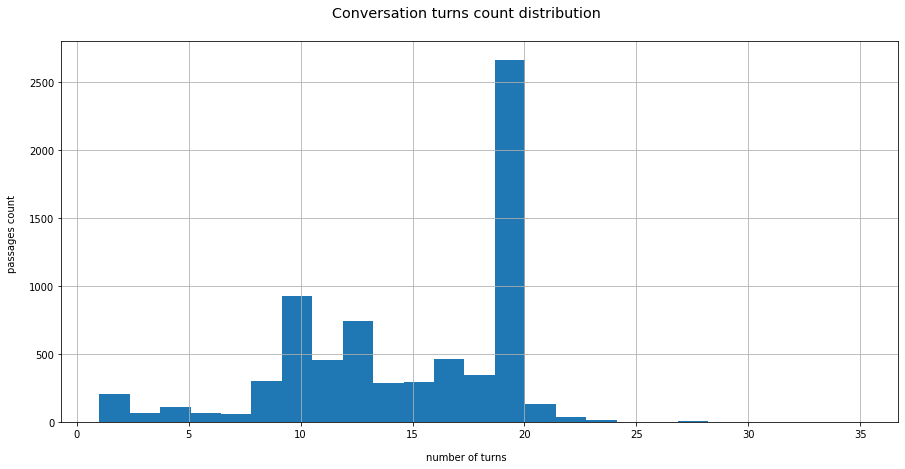

In [23]:
from utils.dataset_analisys import *
plot_converstion_length_distribution(grouped_train_df)

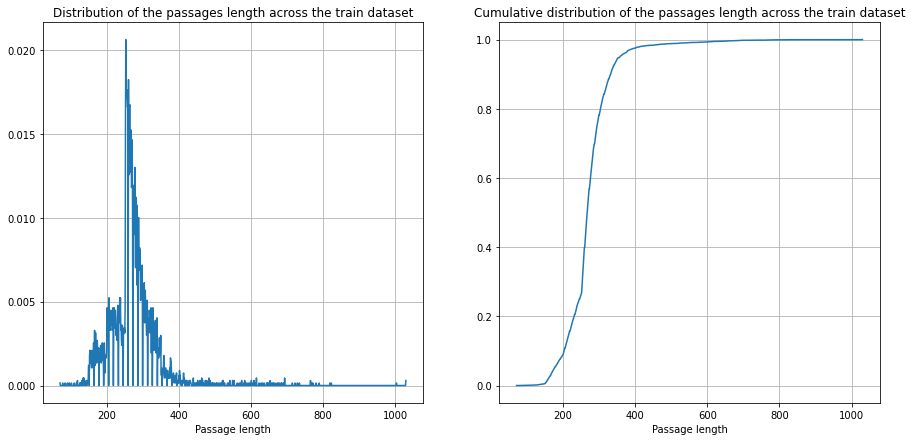

In [24]:
plot_passage_length_analysis(grouped_train_df.story.unique())

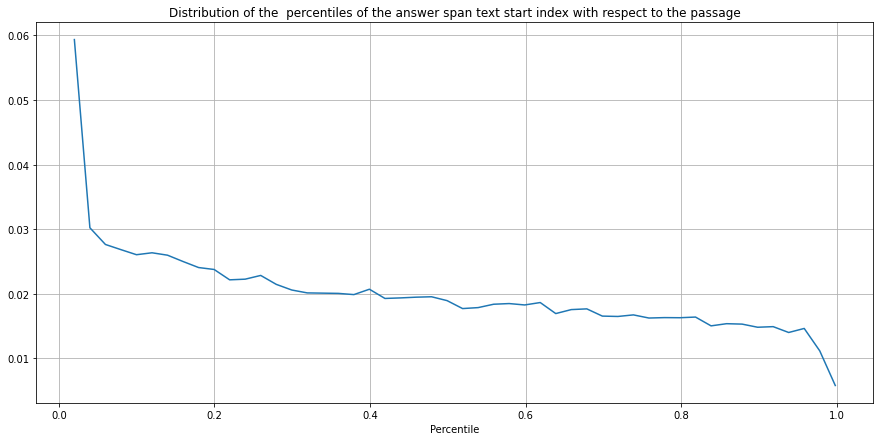

In [25]:
plot_answer_span_text_percentile(train_df)

## [Task 2] Train, Validation and Test splits

In this section the train dataframe is split into an actual train and a validation dataframes.

The split is performed as follows:
1. The random seed is set to $42$ for reproducibility purposes.
2. The train proportion of the actual training dataset to the original dataset is of $0.8$.
3. The train dataframe is shuffled and divided into the two new dataframes making sure that no conversation is split among them.

In [26]:
set_random_seed(42)

In [27]:
from sklearn.model_selection import GroupShuffleSplit
from typing import Tuple

def train_validation_split(df: pd.DataFrame, train_size: int = .8, random_seed: int = 42) \
    -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Get train and validation dataframes by shuffling and splitting an original dataframe according to a given proportion
    and a specific random seed.
    
    Note: The order of the rows of the same conversation is preserved in the shuffle. Moreover, the conversations are never
    split across the two resulting dataframes.

    Parameters
    ----------
    df : DataFrame
        The dataframe from which the train and validation dataframes are obtained.
    train_size : int, optional
        The proportion of the train split. Defaults to 0.8.
    random_seed : int, optional
        The random seed for the shuffle. Defaults to 42.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: _description_
    """
    # Get indices of train and test rows in the dataframe
    group_shuffle_split = GroupShuffleSplit(n_splits=2, train_size=train_size, random_state=random_seed)
    train_ix, test_ix = next(group_shuffle_split.split(df, groups=df.id))

    train_df = df.loc[train_ix]
    train_df.reset_index(inplace=True, drop=True)
    
    val_df = df.loc[test_ix]
    val_df.reset_index(inplace=True, drop=True)
    
    return train_df, val_df

In [28]:
train_df, val_df = train_validation_split(train_df)

The tail of the obtain dataframe (`train_df`) and the head of the validation dataframe (`val_df`) are shown below to assert that the conversations are not splitted and that their question-answer pairs are still chronologically ordered.

In [29]:
print(f'Train dataframe shape after the split: {train_df.shape}')
train_df.tail()

Train dataframe shape after the split: (85824, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
85819,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,1405,1427,substitute Xabi Alonso,Xabi Alonso,10,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85820,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,1415,1467,Xabi Alonso made his first appearance of the ...,Yes,11,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85821,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,1520,1555,Real moved up to third in the table,third,12,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85822,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,1557,1582,six points behind Barca.,Barca.,13,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."
85823,cnn,31qnsg6a5rtt5m7pens7xklnbwf87b,(CNN) -- Cristiano Ronaldo provided the perfec...,By how much?,1557,1581,six points behind Barca.,six points,14,"[Who was in charge of FIFA?, Sepp Blatter, Wha..."


In [30]:
print(f'Validation dataframe shape after the split: {val_df.shape}')
val_df.head()

Validation dataframe shape after the split: (21452, 10)


,source,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the Auction held?,243,284,Hard Rock Cafe in New York's Times Square,Hard Rock Cafe,1,[]
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they make?,180,210,reaping a total $2 million. \n,$2 million.,2,"[Where was the Auction held?, Hard Rock Cafe]"
2,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,How much did they expected?,292,342,"pre-sale expectations of only $120,000 in sal...","$120,000",3,"[Where was the Auction held?, Hard Rock Cafe, ..."
3,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,WHo buy the Jackson Glove,1295,1365,"Hoffman Ma, who bought the glove on behalf of ...",Hoffman Ma,4,"[Where was the Auction held?, Hard Rock Cafe, ..."
4,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,New York (CNN) -- More than 80 Michael Jackson...,Where was the buyer of the glove from?,1331,1366,"behalf of Ponte 16 Resort in Macau,",Macau,5,"[Where was the Auction held?, Hard Rock Cafe, ..."


In [31]:
print(f'Train passages count: {len(train_df.groupby(by=["id"]))}')
print(f'Validation passages count: {len(val_df.groupby(by=["id"]))}')

print()

len_tot=len(train_df)+len(val_df)
print(f'Train QaA count: {len(train_df)} \t\t Train QaA ratio: {len(train_df)/len_tot:.2f}')
print(f'Validation QaA count: {len(val_df)} \t Validation QaA ratio: {len(val_df)/len_tot:.2f}')

Train passages count: 5754
Validation passages count: 1439

Train QaA count: 85824 		 Train QaA ratio: 0.80
Validation QaA count: 21452 	 Validation QaA ratio: 0.20


In addition, the train, validation and test dataloaders are provided for future training purposes.

In [32]:
from utils.dataloader_builder import get_dataloader

train_dataloader = get_dataloader(train_df, batch_size=8)
val_dataloader = get_dataloader(val_df)
test_dataloader = get_dataloader(test_df)

## [Task 3] Model definition

Distil Roberta

In [35]:
from models.model import Model 

model_name1 = 'distilroberta-base'

M1 = Model(model_name=model_name1, device='cpu')

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializin

Bert Tiny

In [36]:
from models.model import Model 

model_name2 = 'prajjwal1/bert-tiny'

M2 = Model(model_name=model_name2, device='cpu')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.

## [Task 4] Question generation with text passage $P$ and question $Q$

In [54]:
question_sample = [train_df.iloc[0]['question']]
passage_sample = [train_df.iloc[0]['story']]
answer_sample = train_df.iloc[0]['answer']

print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the model: "{M1.generate(passage_sample, question_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "When was the Vat formally opened?"

Predicted answer by the model: ",.,,,, Park,ness,ism"

True answer: "It was formally established in 1475"


## [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

In [55]:
question_sample = [train_df.iloc[5]['question']]
passage_sample = [train_df.iloc[5]['story']]
answer_sample = train_df.iloc[5]['answer']
history_sample = [' <sep> '.join(train_df.iloc[5]['history'])]

print(f'Question sample: "{question_sample[0]}"')
print()
print(f'Predicted answer by the model: "{M1.generate(passage_sample, question_sample, history=history_sample)[0]}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the model: ",.,"

True answer: "into periods"


## [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

Training phase 1
epoch: 1/2, 1/50, 0s 306ms/step, lr: 1e-05, loss: 0.5
epoch: 1/2, 2/50, 1s 530ms/step, lr: 1e-05, loss: 0.463
epoch: 1/2, 3/50, 2s 568ms/step, lr: 1e-05, loss: 0.432
epoch: 1/2, 4/50, 2s 591ms/step, lr: 1e-05, loss: 0.5
epoch: 1/2, 5/50, 3s 602ms/step, lr: 1e-05, loss: 0.504
epoch: 1/2, 6/50, 4s 611ms/step, lr: 1e-05, loss: 0.478
epoch: 1/2, 7/50, 4s 616ms/step, lr: 1e-05, loss: 0.462
epoch: 1/2, 8/50, 5s 617ms/step, lr: 1e-05, loss: 0.448
epoch: 1/2, 9/50, 6s 618ms/step, lr: 1e-05, loss: 0.454
epoch: 1/2, 10/50, 6s 633ms/step, lr: 1e-05, loss: 0.456
epoch: 1/2, 11/50, 7s 631ms/step, lr: 1e-05, loss: 0.45
epoch: 1/2, 12/50, 8s 635ms/step, lr: 1e-05, loss: 0.451
epoch: 1/2, 13/50, 8s 638ms/step, lr: 1e-05, loss: 0.448
epoch: 1/2, 14/50, 9s 640ms/step, lr: 1e-05, loss: 0.46
epoch: 1/2, 15/50, 10s 640ms/step, lr: 1e-05, loss: 0.471
epoch: 1/2, 16/50, 10s 643ms/step, lr: 1e-05, loss: 0.464
epoch: 1/2, 17/50, 11s 643ms/step, lr: 1e-05, loss: 0.479
epoch: 1/2, 18/50, 12s 655

c:\Users\riccardo\Desktop\NLP-assignment-2\models\encoder_decoder_distilroberta.py:145: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


epoch: 1/1, 2/50, 2s 833ms/step, lr: 1e-05, loss: 3.43
epoch: 1/1, 3/50, 3s 1150ms/step, lr: 1e-05, loss: 3.82
epoch: 1/1, 4/50, 5s 1198ms/step, lr: 1e-05, loss: 4.02
epoch: 1/1, 5/50, 6s 1221ms/step, lr: 1e-05, loss: 4.46
epoch: 1/1, 6/50, 8s 1254ms/step, lr: 1e-05, loss: 4.14


KeyboardInterrupt: 

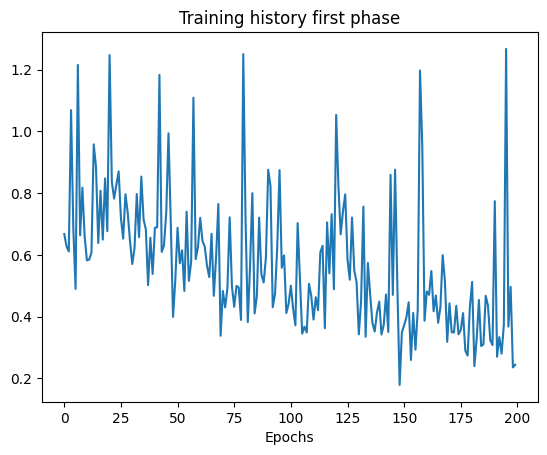

In [39]:
from utils.training import train 

seed = 42
set_random_seed(seed)
train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, model=model, model_name='DistilRoberta', seed=seed, device='cuda', 
      plot=True)

In [37]:
from utils.training import train 

seed = 42
set_random_seed(seed)
train(train_dataloader=train_dataloader, model=model, model_name='DistilRoberta', use_history=True, seed=seed, device='cuda', 
      plot=True)

Training phase 1
epoch: 1/2, 1/42912, 0s 339ms/step, lr: 1e-05, loss: 1.31
epoch: 1/2, 2/42912, 1s 531ms/step, lr: 1e-05, loss: 1.35
epoch: 1/2, 3/42912, 2s 580ms/step, lr: 1e-05, loss: 1.35
epoch: 1/2, 4/42912, 2s 612ms/step, lr: 1e-05, loss: 1.23
epoch: 1/2, 5/42912, 3s 624ms/step, lr: 1e-05, loss: 1.26
epoch: 1/2, 6/42912, 4s 637ms/step, lr: 1e-05, loss: 1.26
epoch: 1/2, 7/42912, 4s 637ms/step, lr: 1e-05, loss: 1.26
epoch: 1/2, 8/42912, 5s 644ms/step, lr: 1e-05, loss: 1.23
epoch: 1/2, 9/42912, 6s 643ms/step, lr: 1e-05, loss: 1.24
epoch: 1/2, 10/42912, 6s 644ms/step, lr: 1e-05, loss: 1.25
epoch: 1/2, 11/42912, 7s 648ms/step, lr: 1e-05, loss: 1.23
epoch: 1/2, 12/42912, 8s 662ms/step, lr: 1e-05, loss: 1.22
epoch: 1/2, 13/42912, 9s 662ms/step, lr: 1e-05, loss: 1.23
epoch: 1/2, 14/42912, 9s 670ms/step, lr: 1e-05, loss: 1.21
epoch: 1/2, 15/42912, 10s 666ms/step, lr: 1e-05, loss: 1.22
epoch: 1/2, 16/42912, 11s 665ms/step, lr: 1e-05, loss: 1.2
epoch: 1/2, 17/42912, 11s 669ms/step, lr: 1e-05

KeyboardInterrupt: 

## [Task 7] Error Analysis

Load weights

In [56]:
M2.load_weigths(tokenImportancesExtractor_weigths_path='./weigths/PQ/seed1337/prajjwal1-bert-tiny_TokenImportancesExtractor.pt',
                encoderDecoder_weigths_path='./weigths/PQ/seed1337/prajjwal1-bert-tiny_EncoderDecoder.pt')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pitti\AppData\Local\Temp\ipykernel_12560\2807241427.py", line 1, in <cell line: 1>
    M2.load_weigths(tokenImportancesExtractor_weigths_path='./weigths/PQ/seed1337/prajjwal1-bert-tiny_TokenImportancesExtractor.pt',
  File "c:\Users\pitti\Desktop\Artificial Intelligence - Master degree\Second year\Natural Language Processing\Assignments\NLP-assignment-2\models\model.py", line 78, in load_weigths
    self.token_importances_extractor.load_state_dict(torch.load(tokenImportancesExtractor_weigths_path))
  File "c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\serialization.py", line 712, in load
    return _load(opened_zipfile, map_location, pickle_module, **pickle_load_args)
  File "c:\Users\pitti\AppData\Local\Programs

In [69]:
from utils.squad import _compute_squad_f1
from tqdm import tqdm

def get_worst_answers(model: Model, df_source, use_history: bool = False, k=5):
    # (f1, question, passage, history if, gold_answer, pred_answer)
    worst_answers = []

    torch.cuda.empty_cache()

    source_dataloader = get_dataloader(df=df_source, batch_size=16)

    for batch_idx, data in tqdm(enumerate(source_dataloader, 0)):
        
        with torch.no_grad():
            # get the inputs; data is a list of [inputs, labels]
            (passage, question, history), (answer, _, _) = data
            
            pred = model.generate(passage,question,history if use_history else None)

            f1_scores = np.array([_compute_squad_f1(gold,predicet) for gold, predicet in zip(answer,pred)])
            samples_indices = np.argsort(f1_scores)[::-1][:k]

            worst_answers += [(f1_scores[sample_idx], question[sample_idx], passage[sample_idx], history[sample_idx], 
                               answer[sample_idx], pred[sample_idx]) 
                              for sample_idx in samples_indices]
            worst_answers = sorted(worst_answers)[::-1][:k]
    
    return worst_answers

In [82]:
it = iter(train_df.groupby(by=['source']))
next(it)
next(it)
df_source = next(it)[1]

C:\Users\pitti\AppData\Local\Temp\ipykernel_12560\3591629657.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  it = iter(train_df.groupby(by=['source']))


In [83]:
df_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6105 entries, 237 to 85665
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   source             6105 non-null   object
 1   id                 6105 non-null   object
 2   story              6105 non-null   object
 3   question           6105 non-null   object
 4   answer_span_start  6105 non-null   int64 
 5   answer_span_end    6105 non-null   int64 
 6   answer_span_text   6105 non-null   object
 7   answer             6105 non-null   object
 8   turn_id            6105 non-null   int64 
 9   history            6105 non-null   object
dtypes: int64(3), object(7)
memory usage: 524.6+ KB


In [84]:
source_dataloader = get_dataloader(df=df_source, batch_size=16)

In [85]:
len(source_dataloader)

382

In [86]:
get_worst_answers(M2, df_source)

0it [00:00, ?it/s]c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
74it [01:42,  1.43s/it]

In [ ]:
from transformers import AutoTokenizer

from utils.build_model import Model

M1_name = 'distilroberta-base'
M2_name = 'prajjwal1/bert-tiny'

tokenizer_1 = AutoTokenizer.from_pretrained(M1_name)
tokenizer_2 = AutoTokenizer.from_pretrained(M2_name)

M1 = Model(M1_name, tokenizer=tokenizer_1)
M2 = Model(M2_name, tokenizer=tokenizer_2)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializin

# Task 4

In [ ]:
from transformers import PreTrainedTokenizer

def f_theta_QP(model: Model, tokenizer: PreTrainedTokenizer, question: str, passage: str, max_length: int = 512, 
               device: str = 'cuda') -> str:
    inputs = tokenizer(question, passage, max_length=max_length, truncation=True, padding=True,
                       return_tensors="pt").to(device)
    generated_ids = model.forward(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, device=device)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [ ]:
question_sample = train_df.iloc[0]['question']
passage_sample = train_df.iloc[0]['story']
answer_sample = train_df.iloc[0]['answer']

print(f'Question sample: "{question_sample}"')
print()
print(f'Predicted answer by the first model: "{f_theta_QP(M1, tokenizer_1, question_sample, passage_sample)}"')
print(f'Predicted answer by the second model: "{f_theta_QP(M2, tokenizer_2, question_sample, passage_sample)}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "When was the Vat formally opened?"

Predicted answer by the first model: ".,"
Predicted answer by the second model: "mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar"

True answer: "It was formally established in 1475"


# Task 5

In [ ]:
from typing import List

def f_theta_QPH(model: Model, tokenizer: PreTrainedTokenizer, question: str, passage: str, history: List[str],
                max_length: int = 512, device: str = 'cuda') -> str:
    separator = f' {tokenizer.sep_token} '
    question_and_history = question + f'{separator if len(history) else ""}' + separator.join(history)
    
    inputs = tokenizer(question_and_history, passage, max_length=max_length, truncation=True, padding=True,
                       return_tensors="pt").to(device)
    generated_ids = model.forward(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, device=device)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [ ]:
question_sample = train_df.iloc[5]['question']
passage_sample = train_df.iloc[5]['story']
history = train_df.iloc[5]['history']
answer_sample = train_df.iloc[5]['answer']

print(f'Question sample: "{question_sample}"')
print()
print(f'Predicted answer by the first model: "{f_theta_QPH(M1, tokenizer_1, question_sample, passage_sample, history)}"')
print(f'Predicted answer by the second model: "{f_theta_QPH(M2, tokenizer_2, question_sample, passage_sample, history)}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the first model: ".,"
Predicted answer by the second model: "mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar mar"

True answer: "into periods"


# Task 6

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, return_history=False):
        self.story=[d['story'] for d in data]
        self.questions=[d['questions'] for d in data]
        self.answers=[d['answers'] for d in data]
        lengths = [len(doc['questions']) for doc in data]
        self.lengths = np.cumsum(np.array(lengths,dtype=np.int32))
        self.R_H=return_history
        self.tokenizer = tokenizer
        

    def __len__(self):
        return self.lengths[-1]

    def __getitem__(self, idx):
        f_idx=int(np.where(self.lengths > idx)[0][0])
        if f_idx>0:
            q_idx=idx-self.lengths[f_idx-1]
        else:
            q_idx=idx

        passage=self.story[f_idx]
        questions=self.questions[f_idx]
        answers=self.answers[f_idx]
        question=questions[q_idx]['input_text']
        answer=answers[q_idx]['input_text']

        if self.R_H:
            print([ [questions[i]['input_text'],answers[i]['input_text']] for i in range(q_idx)])
            history=np.concatenate([ [questions[i]['input_text'],answers[i]['input_text']] for i in range(q_idx)],0)
            return (passage,question,history), answer
        
        #input_ids = torch.tensor(self.encodings['input_ids'])
        #target_ids = torch.tensor(self.labels[idx])
    
        inputs = self.tokenizer(
            question,
            passage,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).input_ids

        labels = self.tokenizer(
            answer,
            max_length=100,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        ).input_ids

        return {"input_ids": inputs.squeeze(0).to('cuda'), "labels": labels.squeeze(0).to('cuda')}

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

data_collator = DataCollatorWithPadding(tokenizer=T2)

# metric = load('accuracy')
training_args = TrainingArguments(output_dir='/prova', evaluation_strategy="epoch", num_train_epochs=3)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

M2.config.decoder_start_token_id = T2.cls_token_id
M2.config.pad_token_id = T2.pad_token_id

trainer = Trainer(
    model=M2,
    tokenizer=T2,
    args=training_args,
    train_dataset=CustomDataset(train, T2),
    eval_dataset=CustomDataset(validation, T2),
    compute_metrics=compute_metrics,
    optimizers=(torch.optim.AdamW(M2.parameters(), lr=0.001), None),
    data_collator=data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 85810
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32181
  Number of trainable parameters = 8935226
 15%|█▍        | 4800/32181 [06:50<37:19, 12.23it/s]Saving model checkpoint to /prova\checkpoint-500
Configuration saved in /prova\checkpoint-500\config.json
Model weights saved in /prova\checkpoint-500\pytorch_model.bin
tokenizer config file saved in /prova\checkpoint-500\tokenizer_config.json
Special tokens file saved in /prova\checkpoint-500\special_tokens_map.json
c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may o

KeyboardInterrupt: 

In [ ]:
import time

In [ ]:
def train(model, tokenizer, n_epochs=3, learning_rate=1e-3):
    model.to('cuda')

    L=[]

    model.config.decoder_start_token_id = tokenizer.cls_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            (passage, question), answer = data

            # text_input = [question[i] + ' [SEP] ' + passage[i] for i in range(len(passage))]

            # zero the parameter gradients
            optimizer.zero_grad()

            inputs = tokenizer(
                question,
                passage,
                padding=True,
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ).input_ids

            labels = tokenizer(
                answer,
                max_length=512,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).input_ids

            #X=torch.tensor(input_ids,device='cuda')
            #y=torch.tensor(labels,device='cuda')
            
            #print(X.shape,y.shape)
            
            #if X.shape[1]>500:
            #    continue

            # the forward function automatically creates the correct decoder_input_ids
            outputs = model(inputs.to('cuda'), labels=labels.to('cuda'))
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            L.append(loss.detach().cpu().numpy())
            
            epoch_time = time.time() - start_time
            batch_time = epoch_time/(i+1)
            
            print(f"epoch: {epoch + 1}/{n_epochs}, {i + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(i+1):.3g}", end = '\r')

        print(f"epoch: {epoch + 1}/{n_epochs}, {i + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(i+1):.3g}")

    print('Finished Training')

In [ ]:
train(M2,T2)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


OutOfMemoryError: CUDA out of memory. Tried to allocate 806.00 MiB (GPU 0; 6.00 GiB total capacity; 4.41 GiB already allocated; 0 bytes free; 4.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Task 7